# Tutorial 2.4: Three-Body Potential Energy Surface

Next, we will parameterize the "physical baseline" ($V_{phys}$) of the PEF.

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

In [1]:
print("test")

test


## 2.1.0 Definitions and Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

In [3]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Normal Modes Configuration Generation

In [5]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O, minimized_energy_H2O = read_system_and_energy(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O_H2O)

In [6]:
clusters_CH3NH2_H2O_H2O = read_systems(definition_CH3NH2_H2O_H2O, paths.clusters.CH3NH2_H2O_H2O)
vibrational_modes_clusters_CH3NH2_H2O_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_H2O_modes)

In [7]:
configurations_vibrational_modes_CH3NH2_H2O_H2O = []

for cluster, modes in zip(clusters_CH3NH2_H2O_H2O, vibrational_modes_clusters_CH3NH2_H2O_H2O):
    configuration_generator = NormalModesConfigurationGenerator(
            cluster,
            modes,
            distribution="linear",
            temperature=(10, 150)
    )

    configs = list(configuration_generator.generate_configurations(num_configs=150, seed=54321))
    configurations_vibrational_modes_CH3NH2_H2O_H2O.extend(configs)
    
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2_H2O_H2O)

Single negative frequency detected in input. This most likely means the given geometry is a transition state.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Will generate configurations over a linear temperature

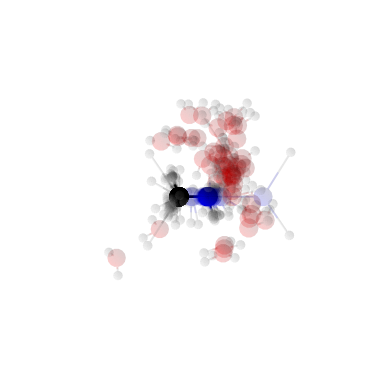

In [8]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
    alpha=0.1,
    num_to_show=25
)

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Random Distance 

RANDOM CONFIGS!

In [9]:
vibrational_modes_CH3NH2 = read_vibrational_modes(paths.structures.vibrational_modes_CH3NH2)

In [10]:
vibrational_modes_H2O = read_vibrational_modes(paths.structures.vibrational_modes_H2O)

In [11]:
generator_CH3NH2 = NormalModesConfigurationGenerator(
        minimized_structure_CH3NH2,
        vibrational_modes_CH3NH2,
)

monomer_configs_CH3NH2 = list(generator_CH3NH2.generate_configurations(num_configs=500, seed=54321))

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.0001644078210115607 | x < 0.45 : 0.0008220391050578035 | x < 0.75 : 0.001644078210115607 | x < 0.95 : 0.003288156420231214 | otherwise : 0.008220391050578035 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 500 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 500 configs.


In [12]:
generator_H2O = NormalModesConfigurationGenerator(
        minimized_structure_H2O,
        vibrational_modes_H2O,
)

monomer_configs_H2O = list(generator_H2O.generate_configurations(num_configs=500, seed=54321))

Will generate configurations over a piecewise temperature distribution.
Temp Distribution: temp (au) = x < 0.05 : 0.00017994063671326814 | x < 0.45 : 0.0008997031835663407 | x < 0.75 : 0.0017994063671326814 | x < 0.95 : 0.0035988127342653628 | otherwise : 0.008997031835663407 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 500 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 500 configs.


In [6]:
# config_generator = RandomDistanceAndRotationConfigurationGenerator(
#         [monomer_configs_CH3NH2, monomer_configs_H2O, monomer_configs_H2O],
#         radius=7.0,
#         min_intermolecular_distance_factor=0.8,
#         logarithmic=True,
#         use_pools=True,
#         num_attempts=100
# )

# random_configs_CH3NH2_H2O_H2O = list(config_generator.generate_configurations(
#         num_configs=3000,
#         seed=12345,
# ))

# write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.random, random_configs_CH3NH2_H2O_H2O)

random_configs_CH3NH2_H2O_H2O = read_systems(definition_CH3NH2_H2O_H2O, paths.PIP_CH3NH2_H2O_H2O.configs.random)

## II.1.? Parallel-Bias Metadynamics Configuration Generation

In [14]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        clusters_CH3NH2_H2O_H2O[0]
)

In [15]:
bond_params

{('A', 'B'): (90, 1.0902050169001265),
 ('A', 'C'): (150, 1.4840322105456125),
 ('C', 'D'): (90, 1.0353028491290241),
 ('E', 'F'): (90, 0.9895932815834846)}

In [16]:
angle_params

{('B', 'A', 'B'): (10, 108.17230750568437),
 ('B', 'A', 'C'): (10, 110.72902281270159),
 ('D', 'C', 'D'): (10, 105.73773276456467),
 ('A', 'C', 'D'): (10, 108.23645918194089),
 ('F', 'E', 'F'): (10, 101.39053903964934)}

In [17]:
nonbonded_params

{'A': (0.03, 2.2),
 'B': (0.01, 1.2),
 'C': (0.03, 2.2),
 'D': (0.01, 1.2),
 'E': (0.03, 2.2),
 'F': (0.01, 1.2)}

In [18]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [30]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O_H2O,
        min_intermolecular_distance=1.5,
        max_intermolecular_distance=6
)

PBMetaD already completed. Will not rerun!


In [31]:
inner_cutoff_3b = 4.5
outer_cutoff_3b = 5.5

In [32]:
num_filtered_configs = filter_configs_by_cutoff(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool,
        threshold=outer_cutoff_3b,
        filtered_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered
)

Found 212554 within cutoff distance of 5.5


In [33]:
split_pool(
        definition_CH3NH2_H2O_H2O,
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_pool_filtered,
        pool_size=num_filtered_configs,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [34]:
pbmetad_configs_CH3NH2_H2O_H2O = perform_fps(
        definition_CH3NH2_H2O_H2O,
        clusters_CH3NH2_H2O_H2O[0],
        vibrational_modes_clusters_CH3NH2_H2O_H2O[0],
        paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_pool,
        num_pool_configs=num_filtered_configs-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=3000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O_H2O,
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 3405 total configs by FPS.


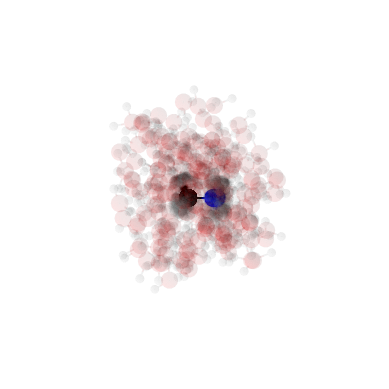

In [18]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05,
    num_to_show=100
)

In [17]:
write_systems(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O_H2O)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [7]:
calculator = Psi4Calculator(
        "MP2",
        "def2-TZVP",
        log_directory=str(paths.logs),
        scratch_directory=str(paths.scratch.psi4)
)

In [41]:
energies_vibrational_modes_CH3NH2_H2O_H2O = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O_H2O,
        num_threads=8,
        mem_mb=16000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_vibrational_modes_CH3NH2_H2O_H2O))

Running energy calculations |====================================================================================================| - 9450/9450
Completed n-mer energy calculations!


In [ ]:
energies_pbmetad_CH3NH2_H2O_H2O = calculate_nmer_energies(
        pbmetad_configs_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_pbmetad_configs_CH3NH2_H2O_H2O,
        num_threads=8,
        mem_mb=16000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2_H2O_H2O, energies_pbmetad_CH3NH2_H2O_H2O))

In [ ]:
energies_random_CH3NH2_H2O_H2O = calculate_nmer_energies(
        random_configs_CH3NH2_H2O_H2O,
        calculator,
        paths.restart.energies_random_configs_CH3NH2_H2O_H2O,
        num_threads=4,
        mem_mb=8000,
        error_on_any_failure=False,
        retrieve_only=False,
        job_manager=get_psi4_job_manager(paths.sub_directory("jobs"))
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O_H2O.configs.random_energies, (random_configs_CH3NH2_H2O_H2O, energies_random_CH3NH2_H2O_H2O))

Waiting for JobManager to begin running...


In [47]:
configurations_vibrational_modes_CH3NH2_H2O_H2O, energies_vibrational_modes_CH3NH2_H2O_H2O = discard_failed_configurations(
        configurations_vibrational_modes_CH3NH2_H2O_H2O,
        energies_vibrational_modes_CH3NH2_H2O_H2O
)

pbmetad_configs_CH3NH2_H2O_H2O, energies_pbmetad_CH3NH2_H2O_H2O = discard_failed_configurations(
        pbmetad_configs_CH3NH2_H2O_H2O,
        energies_pbmetad_CH3NH2_H2O_H2O
)

random_configs_CH3NH2_H2O_H2O, energies_random_CH3NH2_H2O_H2O = discard_failed_configurations(
        random_configs_CH3NH2_H2O_H2O,
        energies_random_CH3NH2_H2O_H2O
)

Checking for missing energies |====================================================================================================| - 1350/1350
Found 19 systems with one or more missing n-mer energies. Remaining configurations: 1331


In [48]:
energies_3b_vibrational_modes_CH3NH2_H2O_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_3b_pbmetad_CH3NH2_H2O_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_3b_random_CH3NH2_H2O_H2O = calculate_many_body_energies(
    random_configs_CH3NH2_H2O_H2O,
    energies_random_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

In [50]:
energies_binding_vibrational_modes_CH3NH2_H2O_H2O = calculate_binding_energies(
    configurations_vibrational_modes_CH3NH2_H2O_H2O,
    energies_vibrational_modes_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_binding_pbmetad_CH3NH2_H2O_H2O = calculate_binding_energies(
    pbmetad_configs_CH3NH2_H2O_H2O,
    energies_pbmetad_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

energies_binding_random_CH3NH2_H2O_H2O = calculate_binding_energies(
    random_configs_CH3NH2_H2O_H2O,
    energies_random_CH3NH2_H2O_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O, minimized_energy_H2O]
)

In [42]:
write_training_set_file(
        paths.PIP_CH3NH2_H2O_H2O.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2_H2O_H2O, *pbmetad_configs_CH3NH2_H2O_H2O, *random_configs_CH3NH2_H2O_H2O],
                [*energies_binding_vibrational_modes_CH3NH2_H2O_H2O, *energies_binding_pbmetad_CH3NH2_H2O_H2O, *energies_binding_random_CH3NH2_H2O_H2O],
                [*energies_3b_vibrational_modes_CH3NH2_H2O_H2O, *energies_3b_pbmetad_CH3NH2_H2O_H2O, *energies_3b_random_CH3NH2_H2O_H2O],
        )
)

## II.1.? Polynomial Generation

In [106]:
pip_3b_max_order = 2

In [ ]:
generate_polynomial(
        definition_CH3NH2_H2O_H2O,
        max_degree=pip_3b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.polynomial,
        filters=[
                "add_filter['sum-degree', 'x-inter-*+*-*', '0']",
                # "add_filter['sum-degree', 'x-intra-*+*-*', '2+']",
        ]
)

## II.1.? Polynomial Parametrization

In [108]:
polarizabilities = read_parameters(paths.Vphys.polarizabilities)
polarizability_factors = read_parameters(paths.Vphys.polarizability_factors)
charges = read_parameters(paths.Vphys.charges)
C6 = read_parameters(paths.Vphys.C6)
d6 = read_parameters(paths.Vphys.d6)

In [ ]:
print("polarizabilities:", polarizabilities)
print("polarizability_factors:", polarizability_factors)
print("charges:", charges)
print("C6:", C6)
print("d6:", d6)

In [110]:
generate_pip_parametizer(
        definition_CH3NH2_H2O_H2O,
        max_degree=pip_3b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.polynomial,
        parametizer_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parameterizer,
        workdir=paths.scratch.PIP_CH3NH2_H2O_H2O,
        symmetry_to_charge=charges,
        symmetry_to_polarizability=polarizabilities,
        symmetry_to_polarizability_factor=polarizability_factors,
        symmetries_to_C6=C6,
        symmetries_to_d6=d6,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        is_mbpol=[False, True, True]
)

File Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.backup-6 to make way for new file.
Completed generating config file Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.
File Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.backup-7 to make way for new file.
Executing python generator script
Generating fitcode for molecule with symmetry A1B3C1D2_E1F2...
Using mbpol for 1 fragments.
0 fragments have lone pairs.
Using exp variables for intramolecular interactions.
Using exp variables for intermolecular interactions.
Using coul variables for lone pair interactions.
160 terms in the polynomial.
Atoms in the molecule: A1 B1 B2 B3 C1 D1 D2 E1 F1 F2.
45 variables in the polynomial.
18 non-linear parame

In [111]:
parametrize_pip(
        definition_CH3NH2_H2O_H2O,
        parametizer_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2_H2O_H2O.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2_H2O_H2O.training_set,
        workdir=paths.scratch.fitting_CH3NH2_H2O_H2O,
        monomer_names=["ch3nh2", "h2o", "h2o"],
        is_mbpol=[False, True, True],
        num_fits_to_run=5,
        num_threads=16,
        DE=10,
        alpha=0.0005
)

Succesfully created fit folder fit1.
Succesfully created fit folder fit2.
Succesfully created fit folder fit3.
Succesfully created fit folder fit4.
Succesfully created fit folder fit5.
fit3 is running.

fit3 is completed.
fit4 is running.

fit4 is completed.
fit1 is running.

fit1 is completed.
fit5 is running.

fit5 is completed.
fit2 is running.

fit2 is completed.
Looks like the fit in fit3 didn't converge...
Maybe you want to rerun fit3 again.
Looks like the fit in fit4 didn't converge...
Maybe you want to rerun fit4 again.
Looks like the fit in fit1 didn't converge...
Maybe you want to rerun fit1 again.
Looks like the fit in fit5 didn't converge...
Maybe you want to rerun fit5 again.
Looks like the fit in fit2 didn't converge...
Maybe you want to rerun fit2 again.
Best fit is fit fit3.
Fit with lowest RMSD did not converge, maybe run it again with more iterations?
Still using that fit as the best one.
No previous best fit, so just storing the current best fit.
Best fit found has a